### Regression 

There's a **range** of potential outcomes. 

A model prediction can't be right/wrong. But, we can minimize the **loss**.

### Loss

The extent to which our model behaves from the “ideal”

Ex: 

$$
    l_w(x_i,y_i)=(h(x_i)-y_i)^2
$$

If the model is: 

$
    \begin{aligned}
    h(x) 
        &=mx+b \\
        &=\langle\langle m,b \rangle,\langle x_i, 1\rangle\rangle \\
        &=\langle w, x'_i \rangle
    \end{aligned}
$

### Empirical Loss Minimization

The minimal loss based on the data that we do have: 

$$
    \text{argmin}_w[\frac{1}{n}\sum_{i=1}^nl_w(\vec{x_i}, \vec{y_i})]
$$

Goal: Find $w$ which minimizes this

## Example

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the data from the CSV file
data = pd.read_csv('sampleData1.csv')

D = pd.DataFrame(data)
d = 2
label_col = 'Rank'

max_outcome = D[label_col].max()
min_outcome = D[label_col].min()

In [ ]:
def plotData2D():
    fig, ax = plt.subplots()
    ax.margins(.2)
    norm = plt.Normalize(min_outcome, max_outcome)
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(norm(data['Rank']))
    scatter = ax.scatter(data['SAT'], data['GPA'], c=colors)
    cbar = plt.colorbar(scatter, ax=ax, label='Rank')
    cbar.set_ticks(ticks=[0, 1], labels=["Min Rank", "Max Rank"])
    return fig, ax

fig, ax = plotData2D()
plt.show()

In [141]:
def get_linear_model(w: np.ndarray, b: float):
    return lambda x: np.dot(np.transpose(w), x) + b
# Loss function, (x: feature vector, y: label) => (model(x) - y)^2
def get_loss_function(model):
    return lambda x, y: (model(x) - y)**2

In [ ]:
# 2D EXAMPLE (using only the features of D, 'SAT' & 'GPA')
MODEL = get_linear_model(np.array([0.0017]), 0.275)
LOSS = get_loss_function(MODEL)

fig, ax = plotData()

# plot the model on the same axis
model_x = range(1600, 2100)
model_y = [MODEL([i]) for i in model_x]
ax.plot(model_x, model_y, color='orange')

# plot the loss on the same axis
for i in data.index:
    x, y = data.loc[i, 'SAT'], data.loc[i, 'GPA']
    ax.plot([x, x], [y, MODEL([x])], color='red')

# Expected Loss

exp_loss = sum([LOSS(data.loc[i, 'SAT'], data.loc[i, 'GPA']) for i in data.index]) / len(data.index)
print('expected loss:', exp_loss)

In [ ]:
# 3D EXAMPLE (using all features of D)

from mpl_toolkits.mplot3d import Axes3D

def plotData3D(data: pd.DataFrame, labelCol: str):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.margins(.2)
    # Generate a color-map
    norm = plt.Normalize(min_outcome, max_outcome)
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(norm(data[label_col]))
    scatter = ax.scatter(data.iloc[:, 0], data.iloc[:, 1], data[label_col], c=colors)
    ax.set_xlabel(data.columns[0])
    ax.set_ylabel(data.columns[1])
    cbar = plt.colorbar(scatter, ax=ax, label='Rank')
    cbar.set_ticks(ticks=[0, 1], labels=[f"Min {labelCol}", f"Max {labelCol}"])
    return fig, ax

def plot3DModel(ax, model, data):
    # Model is a function that takes a feature vector and returns a prediction. In 3D, it is a line in space. Plot this line on the graph.
    x = np.linspace(data.iloc[:, 0].min(), data.iloc[:, 0].max(), 100)
    y = np.linspace(data.iloc[:, 1].min(), data.iloc[:, 1].max(), 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([model([X[i, j], Y[i, j]]) for i in range(X.shape[0]) for j in range(X.shape[1])]).reshape(X.shape)
    ax.plot_surface(X, Y, Z, alpha=0.5)

plotData3D(D, 'Ranl')

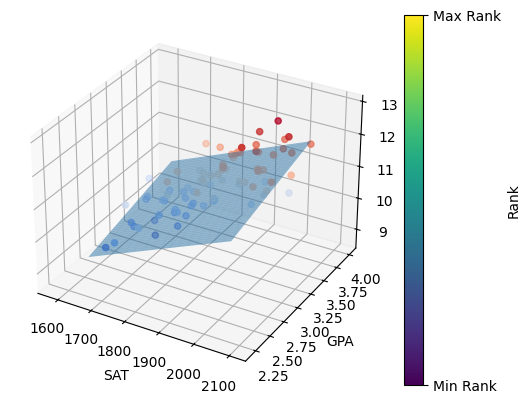

In [158]:
model = get_linear_model(w=[0.0044, 0.5948], b=0.699)
loss = get_loss_function(model)
fig, ax = plotData3D(D, 'Rank')
plot3DModel(ax, model, D)

# Finding Min-Loss Parameters

### Brute Force Search

In [122]:
# Plot the expected loss, x-axis = m, y-axis = b and z-axis = loss (color indicates size)
m_b_loss = []
for m in np.arange(0, 0.005, 0.0001):
    for b in np.arange(-4, 4, 0.05):
        model = get_linear_model(np.array([m]), b)
        loss = get_loss_function(model)
        exp_loss = sum([loss(data.loc[i, 'SAT'], data.loc[i, 'GPA']) for i in data.index]) / len(data.index)
        m_b_loss.append([m, b, exp_loss])

m_b_loss = pd.DataFrame(m_b_loss, columns=['m', 'b', 'loss'])

In [ ]:
# Plot as 2D heatmap
pivot_table = m_b_loss.pivot_table(values='loss', index='m', columns='b').astype(float)
plt.figure(figsize=(10, 8))
plt.imshow(pivot_table, aspect='auto', cmap='hot', origin='lower', extent=[pivot_table.columns.min(), pivot_table.columns.max(), pivot_table.index.min(), pivot_table.index.max()])
plt.colorbar(label='Loss')
plt.xlabel('m')
plt.ylabel('b')
plt.title('Expected Loss for Different Values of m and b')
plt.show()

Text(0.5, 0.5, 'b')

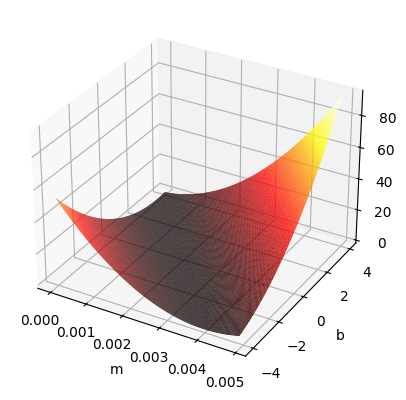

In [159]:
# Plot as 3D (loss = height)
m_b_loss = m_b_loss.astype(float)  # Ensure all columns are float
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(m_b_loss['m'], m_b_loss['b'], m_b_loss['loss'], cmap='hot')
ax.set_xlabel('m')
ax.set_ylabel('b')

# Gradient, Hessian

### Gradient 

Is the derivative of a function, 
$ f(\vec{x}): \mathbb{R}^d \rarr \mathbb{R} $

$$
\triangledown f(\vec{x}) 
= (\frac{\partial f}{\partial x_1}+\dots +\frac{\partial f}{\partial x_d})
: \mathbb{R^d} \rarr \mathbb{R^d}
$$